In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [4]:
import sys, os, sys, math
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm
from jfi.experimental.jit import autojit, nestedautojit

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from mpcjax import solve
from tests.dynamics import f_fx_fu_fn

In [5]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1e0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

problem = dict(
    f_fx_fu_fn=f_fx_fu_fn,
    Q=Q,
    R=R,
    x0=x0,
    X_ref=X_ref,
    U_ref=U_ref,
    X_prev=X_prev,
    U_prev=U_prev,
    u_l=u_l,
    u_u=u_u,
    solver_settings=dict(smooth_alpha=1e0, solver="cvx", linesearch="scan", maxls=10),
    reg_x=1e0,
    reg_u=1e0,
    max_it=20,
    res_tol=1e-12,
    verbose=True,
    slew_rate=1e-2,
    P=1.0 * jaxm.ones((N,)),
    dtype=np.float32,
    device="cpu",
)

In [2]:
X, U, data = solve(**problem)
print(f"dtype = {X.dtype}, device = {X.device()}")

NameError: name 'solve' is not defined

In [71]:
def solve(H, g, dtype=jaxm.float64):
    return jaxm.linalg.solve(*jaxm.to((H, g), dtype=dtype))

def solve_precond(H, g, L, R, dtype=jaxm.float64):
    H, g, L, r = jaxm.to((H, g, L, R), dtype=dtype)
    H = jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)
    g = g / L
    return jaxm.linalg.solve(H, g) / R

def cond(H):
    return jaxm.linalg.cond(jaxm.to(H, device="cpu", dtype=jaxm.float64))

In [74]:
H = jaxm.randn((100, 100))
g = jaxm.randn((100,))
Q = jaxm.linalg.qr(H)[0]
H = Q @ jaxm.diag(jaxm.logspace(-9, 0, Q.shape[-1])) @ Q.T

ys = solve(H, g)
L, R = jaxm.linalg.norm(H, axis=-1), jaxm.linalg.norm(H, axis=-2)
L2, R2 = jaxm.linalg.norm(H, axis=-2), jaxm.linalg.norm(H, axis=-1)

print(f"{jaxm.norm(ys - solve(H, g, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, R2, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R2, jaxm.float32)) / jaxm.norm(ys):.4e}")

4.9932e+00
1.9298e+01
1.9298e+01
1.9298e+01
1.9298e+01
8.3982e-01
8.3982e-01


In [70]:
print(f"{cond(jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L) @ H):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(H):.4e}")

8.6951e+04
8.6951e+04
8.8527e+04
8.8527e+04
8.8527e+04
8.8527e+04
1.0000e+05


[]

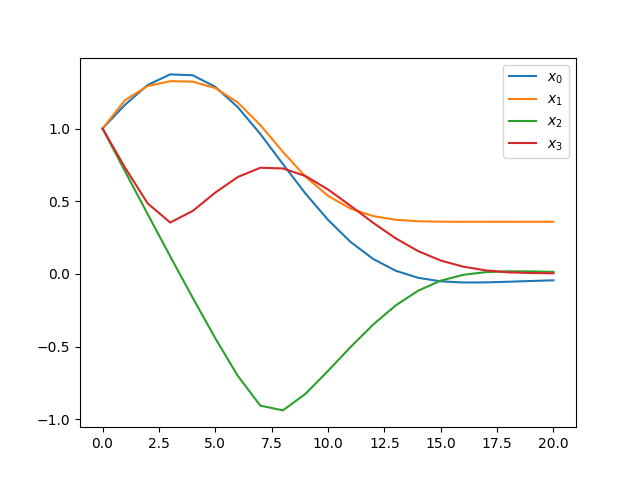

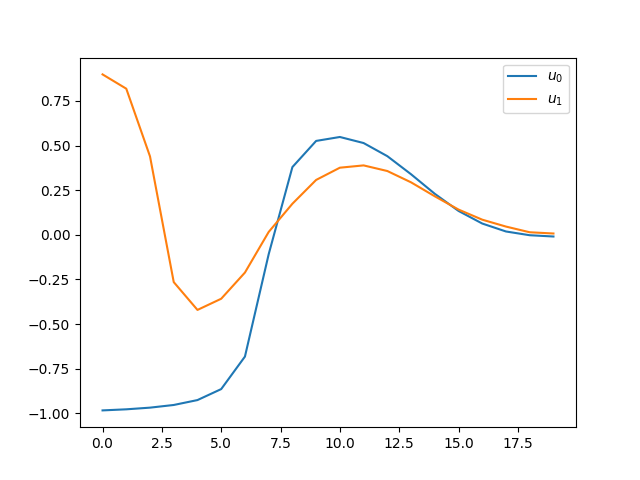

In [40]:
plt.figure()
for i in range(X.shape[-1]):
    plt.plot(X[:, i], label=f"$x_{i}$")
plt.legend()
plt.plot()
plt.figure()
for i in range(U.shape[-1]):
    plt.plot(U[:, i], label=f"$u_{i}$")
plt.legend()
plt.plot()